In [11]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from solve_consumption_saving import *
from copy import deepcopy
from estimation import *

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_standard = deepcopy(model)    # Used later for standard model
model.par.model = 'ConSav'
model_standard.par.model = 'ConSav'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [12]:
# Setup
model.par.eta = 1  # Reference dependence
model.par.types = 1  # No heterogeneity
model.par.euler = True
model.allocate()

# Estimation setup
est_par = ['delta', 'gamma', 'lambdaa', 'cost1', 'L'] # Parameters to estimate
theta0 = [0.95, 0.4, 2.0, 100.0, -0.5]  # Initial guesses
bounds = [(0.5, 1), (0.001, 10.0), (0.0, 10.0), (0.0,500), (-0.9,-0.001)] # Bounds for the parameters



# Random starting values:
model.par.noOfParams = len(est_par)
model.par.noSearchInits = 10
np.random.seed(180615)
est_best = np.inf

for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
              np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
              np.random.uniform(model.par.lb_lambdaa,model.par.ub_lambdaa),
              np.random.uniform(model.par.lb_c,model.par.ub_c),
              np.random.uniform(model.par.lb_L,model.par.ub_L)]

    
    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model, est_par, theta0, bounds, weight=True)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit
            obj_ref = est_best

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue



# print("Optimization Results:")
# print("---------------------")
# print(f'{"Parameter":<15} {"Estimate":<15}')
# for param, estimate in zip(est_par, par):
#     print(f'{param:<15} {estimate:>15.3f}')
# print(f'Objective:               {est_best:.4f}')
# print(f'Number of iterations:    {nit}')

/Users/sophiebune/Desktop/Dynamic-programming-project/Funcs.py:64: RuntimeWarning: invalid value encountered in scalar power
  inv_c_marg[0] = (s/par.cost1)**(1/par.gamma)
/Users/sophiebune/Desktop/Dynamic-programming-project/Funcs.py:65: RuntimeWarning: invalid value encountered in scalar power
  inv_c_marg[1] = (s/par.cost2)**(1/par.gamma)
/Users/sophiebune/Desktop/Dynamic-programming-project/Funcs.py:66: RuntimeWarning: invalid value encountered in scalar power
  inv_c_marg[2] = (s/par.cost3)**(1/par.gamma)


Error at t=15, i_a=0
Error message: NaN result encountered.
Current function value: 4.052070882431602
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 4.052070882431602
       x: -0.8996405445648087
     nit: 23
    nfev: 23
Error at t=14, i_a=1
Error message: NaN result encountered.
Current function value: 1.7687779775008738
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 1.7687779775008738
       x: -0.8508689426485635
     nit: 23
    nfev: 23
Error at t=14, i_a=2
Error message: NaN result encountered.
Current function value: 1.2956222446933559
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 1.2956222446933559
       x: -0.8508688681526005
     nit: 25
    nfev: 25
Error at t=12, i_a=0
Error message: NaN result encountered.
Current function value: 3.86029790404032
Optimization result details:  message: NaN result encountered.
 

/Users/sophiebune/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Error at t=1, i_a=4
Error message: NaN result encountered.
Current function value: 1.4102750203230245
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 1.4102750203230245
       x: -0.8913385678715184
     nit: 25
    nfev: 25
Error at t=0, i_a=0
Error message: NaN result encountered.
Current function value: 2.558119435893841
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: 2.558119435893841
       x: -0.8834914652971834
     nit: 24
    nfev: 24
Error at t=44, i_a=0
Error message: NaN result encountered.
Current function value: nan
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: nan
       x: -0.8149869606906597
     nit: 21
    nfev: 21
Error at t=44, i_a=1
Error message: NaN result encountered.
Current function value: nan
Optimization result details:  message: NaN result encountered.
 success: False
  status: 2
     fun: nan
    

In [13]:
# Calculates standard errors
jacobian = manual_jacobian(model, est_par, par)

moments_before = model.data.moments_before
moments_before = moments_before.reshape(35)

moments_after = model.data.moments_after
moments_after = moments_after.reshape(35)

data_moments = np.concatenate((moments_before, moments_after))
data_moments = data_moments.reshape(70, 1)

model_moments = model_moments_combined(model,est_par,theta0)   

# # Ligesom artiklen

# def standard_errors(jac, weight_matrix, N = 70):

#     model_moments = model_moments_combined(model, est_par, par)
#     G = np.zeros((jac.shape))
#     for i in range(N):
#         G += 1/N*jac*model_moments[i]
  
#     G = G.T
#     Lambda = np.var(model_moments)

#     # diagonal Variance matirx for data moments
#     Lambda = np.var(model_moments)
#     Lambda = np.eye(N)*Lambda
   
#     # Compute (G'WG)
#     gwg_inv = la.pinv(G.T @ weight_matrix @ G)

#     # Compute the middle term G'WVWG
#     middle_term =  G.T @ weight_matrix @ Lambda @ weight_matrix @ G


#     # Compute the variance
#     variance = 1/N*gwg_inv @ middle_term @ gwg_inv.T
#     print(variance.shape)
#     variance = np.diag(variance)

#     standard_errors = np.sqrt(variance/N)

#     return standard_errors

# standard_errs = standard_errors(jacobian, model.data.weight_mat, N = 70)
# print(standard_errs)

# # Calculates standard errors
# jacobian = manual_jacobian(model, est_par, par)

# moments_before = model.data.moments_before
# moments_before = moments_before.reshape(35)

# moments_after = model.data.moments_after
# moments_after = moments_after.reshape(35)

# data_moments = np.concatenate((moments_before, moments_after))
# data_moments = data_moments.reshape(70, 1)

# Ligesom Bertels Slides

standard_errs = standard_errors(jacobian, model.data.weight_mat, data_moments, model_moments, N = 70)
print(standard_errs)

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15} {"Std. Error":<15}')
for param, estimate, error in zip(est_par, par, standard_errs):
    print(f'{param:<15} {estimate:>15.3f} {error:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')

(5, 70)
(70, 70)
(5, 5)
(5, 5)
(5, 5)
[8.61739663e-03 1.39254696e-01 6.51446659e-02 1.37232998e+02
 7.22444404e-02]
Optimization Results:
---------------------
Parameter       Estimate        Std. Error     
delta                     0.788           0.009
gamma                     0.953           0.139
lambdaa                   5.009           0.065
cost1                   324.875         137.233
L                        -0.128           0.072
Objective:               0.0435
Number of iterations:    8


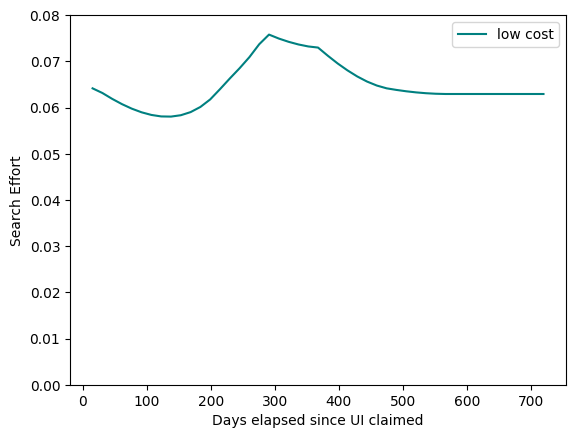

In [14]:
# Plot policy functions
value_function_employment_ConSav(model.par, model.sol)
solve_search_and_consumption_ConSav(model.par, model.sol)
search_effort_reference = model.sol.s
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort_reference[0,:,0], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort[1,:,0], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
# plt.title('Policy functions with reference dependence, Before the reform')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

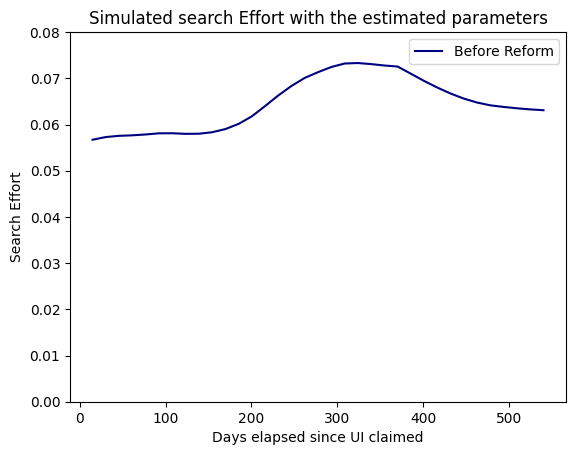

In [15]:
# Policy function before reform
model.solve()
search_reference_beforeReform = model.sim.s_total
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_beforeReform[:], color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

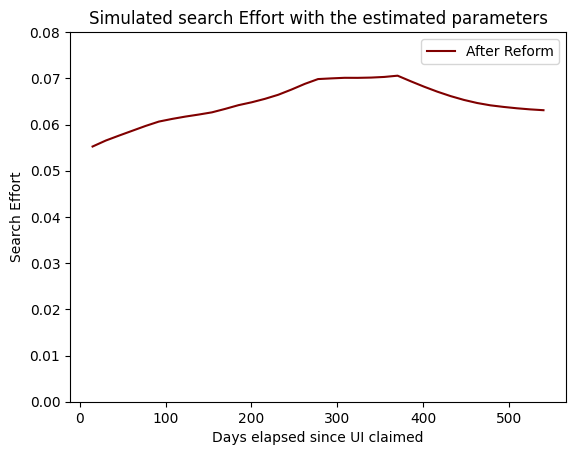

In [16]:
# Policy function after reform
model_afterReform = deepcopy(model)
model_afterReform.par.b1 = 342.0/675.0      # Value after reform
model_afterReform.par.b2 = 171.0/675.0      # Value after reform

model_afterReform.allocate()
search_reference_afterReform = model_afterReform.solve()

# true_data_afterReform = model.data.moments_after
# true_data_beforeReform = model.data.moments_before
# mse_reference_afterReform = np.mean((true_data_afterReform - search_reference_afterReform)**2)
# mse_reference_beforeReform = np.mean((true_data_beforeReform - search_reference_beforeReform)**2)

# Now plotting search_reference_afterReform
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_afterReform, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

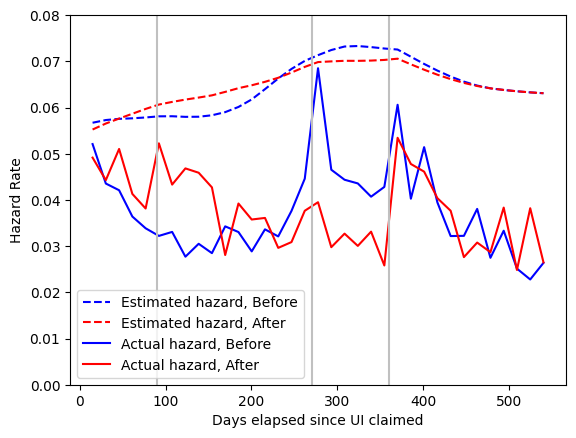

In [17]:
#Replicating figure 7(b) from the paper
after = model_standard.data.moments_after
before = model_standard.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, search_reference_beforeReform[:model.par.T_sim], color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, search_reference_afterReform, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
# plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [18]:
# Setup
model_standard.par.eta = 0.0     # Removes reference dependence
model_standard.par.types = 3     # Allow for heterogeneity
model_standard.allocate()

# Estimation setup
est_par = ['delta','gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3', 'L'] # Parameters to estimate
theta0 = [0.9, 0.9, 84, 242, 310, 0.4, 0, -0.3] # Initial guesses
bounds = [(0.5,1.0), (0.001, 50.0), (0.0, 100), (30, 300), (300, 1000), (0,0.9), (0,1-model_standard.par.type_shares1), (-0.9,-0.001)] # Bounds for the parameters


# Random starting values:
model.par.noOfParams = len(est_par)
model.par.noSearchInits = 10
np.random.seed(180615)
est_best = np.inf

for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(model.par.lb_delta, model.par.ub_delta),
              np.random.uniform(model.par.lb_gamma,model.par.ub_gamma),
              np.random.uniform(model.par.lb_lsc,model.par.ub_lsc),
              np.random.uniform(model.par.lb_msc,model.par.ub_msc),
              np.random.uniform(model.par.lb_hsc,model.par.ub_hsc),
              np.random.uniform(model.par.lb_share,model.par.ub_share),
              np.random.uniform(model.par.lb_share,model.par.ub_share),
              np.random.uniform(model.par.lb_L,model.par.ub_L)]

    

    try:
        # Perform the method of simulated moments
        est = method_simulated_moments(model_standard, est_par, theta0, bounds, weight=True)

        # Check if the current estimate is better than the best estimate
        if est.fun < est_best:
            est_best = est.fun
            par = est.x
            nit = est.nit
            obj_standard = est_best

    except Exception as e:
        # Print the exception message and continue with the next iteration
        print(f"Iteration {i} failed with error: {e}")
        continue

# print("Optimization Results:")
# print("---------------------")
# print(f'{"Parameter":<15} {"Estimate":<15}')
# for param, estimate in zip(est_par, par):
#     print(f'{param:<15} {estimate:>15.3f}')
# print(f'Objective:               {est_best:.4f}')
# print(f'Number of iterations:    {nit}')

In [ ]:
# Calculates standard errors
jacobian = manual_jacobian(model_standard, est_par, par)
model_moments = model_moments_combined(model_standard,est_par,theta0)   

standard_errs = standard_errors(jacobian, model.data.weight_mat, data_moments, model_moments, N = 70)
print(standard_errs)

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15} {"Std. Error":<15}')
for param, estimate, error in zip(est_par, par, standard_errs):
    print(f'{param:<15} {estimate:>15.3f} {error:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')

In [ ]:
# Plot policy functions
value_function_employment_ConSav(model_standard.par, model_standard.sol)
solve_search_and_consumption_ConSav(model_standard.par, model_standard.sol)
search_effort_standard = model_standard.sol.s

time = np.linspace(0, model_standard.par.T, model_standard.par.T)
plt.plot((time+1)*15, search_effort_standard[0,:,0], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort_standard[1,:,0], label = 'medium cost', color='orange') 
# plt.plot((time+1)*15, search_effort_standard[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
# plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

In [ ]:
# Policy function before reform
model_standard.par.b1 = 222/675*model_standard.par.w    # High transfers
model_standard.par.b2 = model_standard.par.b1    # Medium transfers
model_standard.allocate()
model_standard.solve()
search_standard_beforeReform = model_standard.sim.s_total

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_beforeReform[:], label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()


In [ ]:
# Policy function after reform
model_standard.par.b1 = 342.0/675.0      # Value after reform
model_standard.par.b2 = 171.0/675.0      # Value after reform

model_standard.allocate()
model_standard.solve()
search_standard_afterReform = model_standard.sim.s_total

# Now plotting s_forecast
time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_afterReform, label='After Reform', color='maroon')
plt.plot((time+1)*15, search_standard_beforeReform[:], label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

In [ ]:
#Replicating figure 7(a) from the paper
after = model_standard.data.moments_after
before = model_standard.data.moments_before

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)
plt.plot((time+1)*15, search_standard_beforeReform, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, search_standard_afterReform, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
# plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [ ]:
# true_data_afterReform = model_standard.data.moments_after
# true_data_beforeReform = model_standard.data.moments_before

# # Get the mean square errors
# mse_standard_afterReform = np.mean((true_data_afterReform - search_standard_afterReform)**2)
# mse_standard_beforeReform = np.mean((true_data_beforeReform - search_standard_beforeReform)**2)

# # Comparison after reform
# comparison1 = "smaller" if mse_reference_afterReform < mse_standard_afterReform else "bigger" if mse_reference_afterReform > mse_standard_afterReform else "equal"
# comparison2 = "WITH reference dependence" if mse_reference_afterReform < mse_standard_afterReform else "WITHOUT reference dependence" 

# # Comparison before reform
# comparison3 = "smaller" if mse_reference_beforeReform < mse_standard_beforeReform else "bigger" if mse_reference_beforeReform > mse_standard_beforeReform else "equal"
# comparison4 = "WITH reference dependence" if mse_reference_beforeReform < mse_standard_beforeReform else "WITHOUT reference dependence"


# print("Before the reform: ")
# print("-" * 100)
# print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_reference_beforeReform}")
# print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_standard_beforeReform}")
# print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
# print(f"Best model: \033[1m{comparison4}\033[0m.")
# print("-" * 100)



# print("After the reform:")
# print("-" * 100)
# print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_reference_afterReform}")
# print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_standard_afterReform}")
# print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
# print(f"Best model: \033[1m{comparison2}\033[0m.")
# print("-" * 100)

### Through objective function

In [ ]:
# Comparison
comparison1 = "Reference Dependent Model" if obj_ref < obj_standard else "Standard Model" if obj_ref > obj_standard else "They are equally good"


print("Comparison: ")
print("-" * 100)
print(f"The objective function from the model \033[1mwith\033[0m reference dependence is {obj_ref}")
print(f"The objective function from the model \033[1mwithout\033[0m reference dependence is {obj_standard}")
print(f"Best model: \033[1m{comparison1}\033[0m.")
print("-" * 100)



In [ ]:
after = model_standard.data.moments_after

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)     # x-axis
plt.plot((time+1)*15, search_standard_afterReform, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, search_reference_afterReform, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
# plt.title('Real and estimated hazard rates before the reform')
plt.ylim(0.0, 0.08)
plt.show()

In [ ]:
before = model_standard.data.moments_before

time = np.linspace(0, model_standard.par.T_sim, model_standard.par.T_sim)     # x-axis
plt.plot((time+1)*15, search_standard_beforeReform, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, search_reference_beforeReform, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
# plt.title('Real and estimated hazard rates before the reform')
plt.ylim(0.0, 0.08)
plt.show()